In [18]:
from drivecycle import trajectory, drivecycle, plots, utils
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

In [90]:
traj = trajectory.const_accel(vi=0,v_target=12,vf=0,di=0,df=450,step=1,a_max=1)
traj = traj[1:]

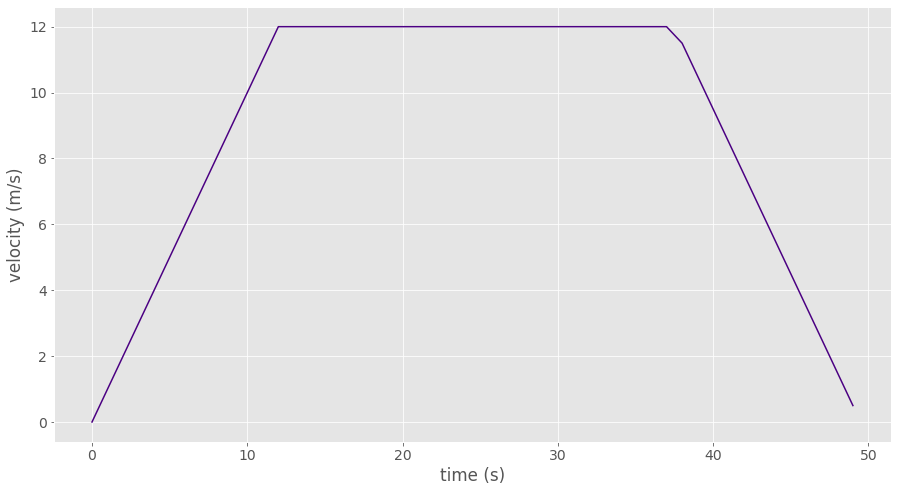

In [91]:
plots.plot_vt(traj, "plot_vt.png")

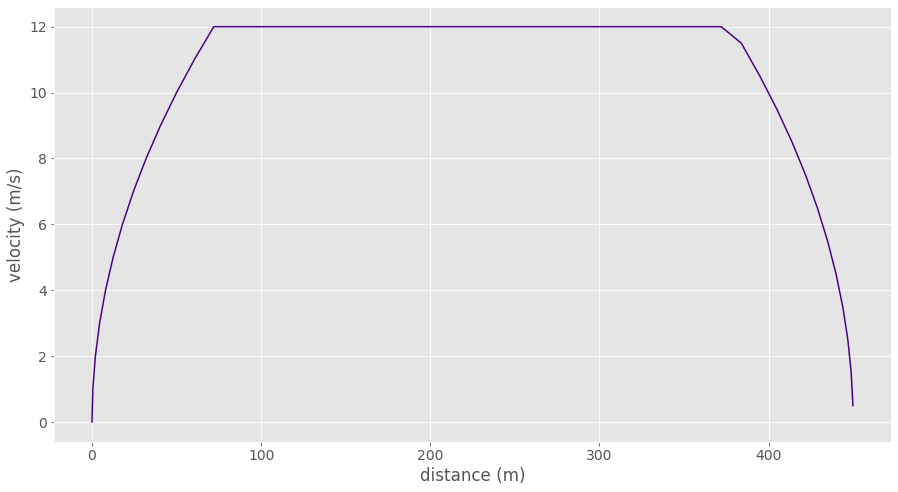

In [92]:
plots.plot_vd(traj, "plot_vd.png")

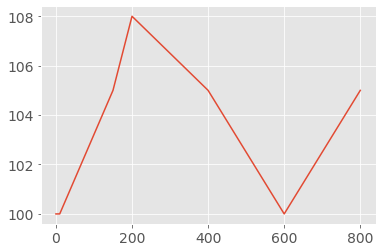

In [93]:
elv = np.array([[0,100],[10,100],[150,105],[200,108],[400,105],[600,100],[800,105]])
x = [i[0] for i in elv]
y = [i[1] for i in elv]
    
plt.plot(x,y)

In [114]:
#Energy Calculation

#Rolling Resistance 

#F_r = f * m * g
#f = (0.0041 + 0.000041 * v * 2.24) * Ch

#Aerodynamic Drag

#F_d = 0.5 * air_density * Cw * A * v^2

#Hill Climbing Force

#F_h = m * g * sin(alpha)

#Acceleration Force

#F_a = m * a



In [117]:
def open_circuit_voltage_LA(x,N):
    return (2.15 - ((2.15-2.00)*x))*N

def open_circuit_voltage_NC(x,N):
    return N*( -8.2816 *(np.power(x,7))  +  23.5749*(np.power(x,6)) -30*(np.power(x,5)) +23.7053*(np.power(x,4)) -12.5877*(np.power(x,3)) + 4.1315*x*x - 0.8658*x +1.37)


In [126]:
def pairwise(iterable):
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)

def energy(
    traj,
    elv,
    Ch = 1.2,
    m = 17048,
    g = 9.81,
    air_density = 1.2,
    Cw = 1.17,
    A = 10,
    r = 0.5,
):
    
    g_ratio = 37 #G/r
    regen_ratio = 0.5
    g_eff = 0.95 #transmission efficiency
    ki = 0.01 #iron losses
    kw = 0.000005 #windage losses
    kc = 0.3 #copper losses
    ConL = 600
    
    I = 30 #Set discharge current to 30 amps
    NoCells=5 # 5 cell battery
    Capacity=50; #This is the normal 3 h rated capacity of the battery
    k=1.045 #peukert coeff
    
    Rin= (0.06/Capacity)*NoCells #Internal resistance, e.q. (3.9)
    PeuCap= (np.power((Capacity/3),k))*3 #See equation (3.18)

    x = [i[0] for i in elv]
    y = [i[1] for i in elv]
    
    elv_f = interpolate.interp1d(x,y)
    
    # V (Voltage), Cr (Charge amphours removed from bat), Cs (charge amphours added to bat), DOD (depth of discharge)
    #V,Cr,Cs,DOD
    data = np.zeros((len(traj),4))
    
    data[0,0] = open_circuit_voltage_LA(0,NoCells) - I*Rin #initial voltage
    
    
    for i, (prev,curr) in enumerate(pairwise(traj)):

        t0,v0,d0 = prev
        t1,v1,d1 = curr

        accel = (v1-v0)/(t1-t0)
        
        alpha = (elv_f(d1)-elv_f(d0))/(d1-d0)
#         alpha = 0

        f = (0.0041 + 0.000041 * v1 * 2.24) * Ch
        Fr = m * f * g

        Fd = 0.5 * air_density * Cw * A * np.power(v1,2)

        Fh = m * g * np.sin(alpha)

        Fa = m * accel

        F = Fr + Fd + Fh + Fa

        Pte = (F*v1)
        
        omega = g_ratio * v1
        
        if omega==0:
            Pte= 0
            Pmot_in= 0
            torque = 0
            eff_mot=0.5
        elif omega>0:
            if Pte<0:
                Pte = regen_ratio * Pte
        
            if Pte >=0:
                Pmot_out = Pte/g_eff
            elif Pte<0:
                Pmot_out = Pte*g_eff
        
            torque = Pmot_out/omega
        
            if torque > 0:
                eff_mot = (torque*omega)/((torque*omega)+(np.power(torque,2)*kc)+(omega*ki)+((np.power(omega,3)*kw)+ConL))
            elif torque<0:
                eff_mot = (-torque*omega)/((-torque*omega)+(np.power(torque,2)*kc)+(omega*ki)+((np.power(omega,3)*kw)+ConL))
        
            if Pmot_out >=0:
                Pmot_in = Pmot_out/eff_mot
            elif Pmot_out <0:
                Pmot_in = Pmot_out * eff_mot
        
        Pac = 0 #accecory power
        Pbat = Pmot_in + Pac
        
        E=open_circuit_voltage_LA(data[i+1,3],NoCells)
        
        if Pbat > 0: #Use Equation (3.26)**
            I = (E - np.power(((E*E) - (4*Rin*Pbat)),0.5))/(2*Rin)
            data[i+1,1] = data[i,1] +(np.power(I,k)/3600); #Equation (3.24)**
        elif Pbat==0:
            I=0
        elif Pbat <0:
            #Regenerative braking. Use Equation (3.28)**, and
            #double the internal resistance.
            Pbat = - 1 * Pbat;
            I = (-E + np.power(E*E + (4*2*Rin*Pbat)),0.5)/(2*2*Rin);
            CR(C) = CR(C-1) - (I/3600); #%Equation (3.29)**
    end;

# #         power.append([t1,Pbat/1000])
        
        
    return power

        
power = energy(traj,elv)
len(traj)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


50

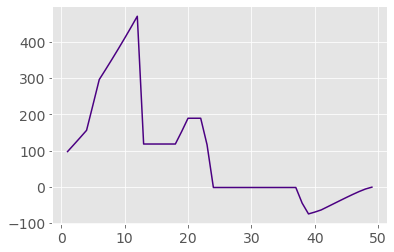

In [113]:
t=[i[0] for i in power]
p=[i[1] for i in power]

plt.plot(t,p, color='#4b0082', linewidth=1.5)

In [89]:
power

[[0.1, 1.7872738457890305],
 [0.2, 3.5749584372361225],
 [0.30000000000000004, 5.363095894341274],
 [0.4, 7.151728337104487],
 [0.5, 8.940897885525759],
 [0.6, 10.730646659605094],
 [0.7, 12.52101677934249],
 [0.7999999999999999, 14.312050364737944],
 [0.8999999999999999, 16.103789535791464],
 [0.9999999999999999, 17.89627641250304],
 [1.0999999999999999, 19.689553114872677],
 [1.2, 21.48366176290038],
 [1.3, 23.278644476586138],
 [1.4000000000000001, 25.07454337592996],
 [1.5000000000000002, 26.871400580931848],
 [1.6000000000000003, 28.669258211591785],
 [1.7000000000000004, 30.468158387909796],
 [1.8000000000000005, 32.26814322988586],
 [1.9000000000000006, 34.069254857519994],
 [2.0000000000000004, 35.87153539081217],
 [2.1000000000000005, 37.67502694976242],
 [2.2000000000000006, 39.47977165437072],
 [2.3000000000000007, 41.28581162463709],
 [2.400000000000001, 43.09318898056152],
 [2.500000000000001, 44.901945842144016],
 [2.600000000000001, 46.712124329384565],
 [2.7000000000000